--- Iniciando Etapa 2: Carregamento e Preparação dos Dados ---
Dataset carregado com sucesso.
Foram encontradas 2000 músicas dos gêneros 'pop' e 'classical'.
Estrutura dos dados de treino: (1600, 13)
Estrutura dos dados de teste: (400, 13)

--- Preparação dos Dados Concluída ---

--- Iniciando Exercício 1: Análise de Clusters ---


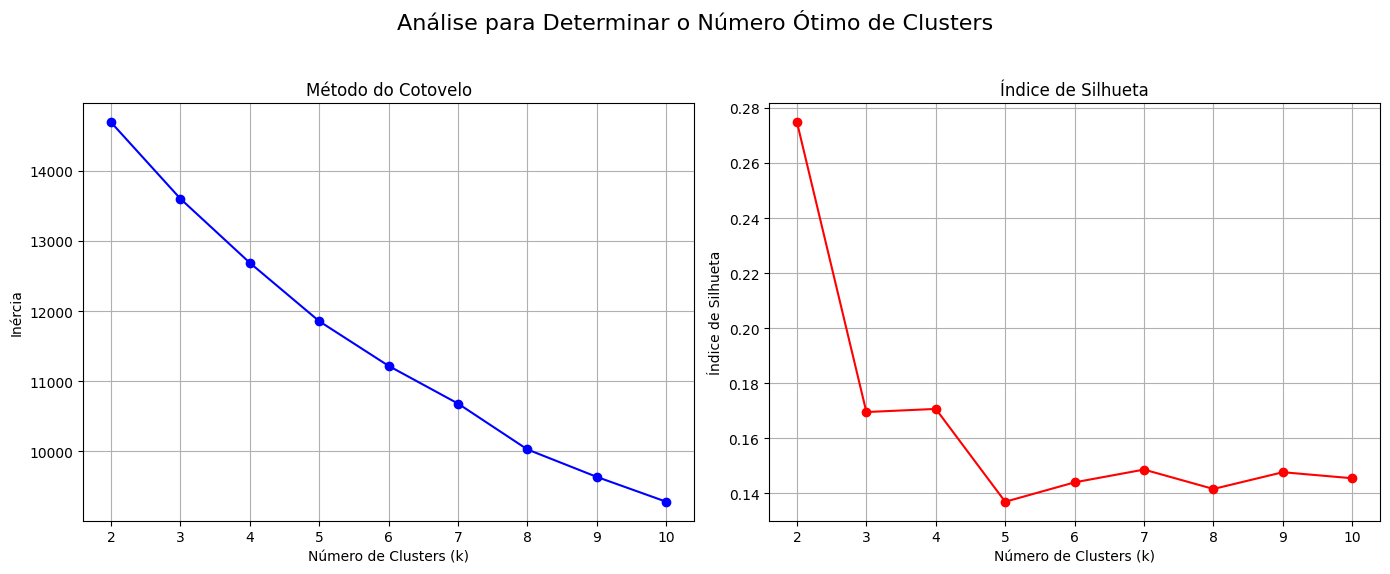

Com base nos gráficos, o número ótimo de clusters escolhido foi: k=3

--- Exercício 1 Concluído ---

--- Iniciando Exercício 2: Criação da Feature de Distância ---
Estrutura do X_train original: (1600, 13)
Estrutura do X_train com nova feature: (1600, 14)

--- Exercício 2 Concluído ---

--- Iniciando Exercício 3: Treinamento e Otimização via GridSearchCV ---

--- Otimizando SVM ---
Melhores parâmetros SVM (Baseline): {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Melhores parâmetros SVM (com Feature de Cluster): {'C': 10, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}

--- Otimizando Random Forest ---
Melhores parâmetros Random Forest (Baseline): {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200}
Melhores parâmetros Random Forest (com Feature de Cluster): {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 200}

--- Exercício 3 Concluído ---

--- Iniciando Exercícios 4 e 5: Avaliação Final e Análise ---

--- Tabela Comparativa de Métricas ---
               

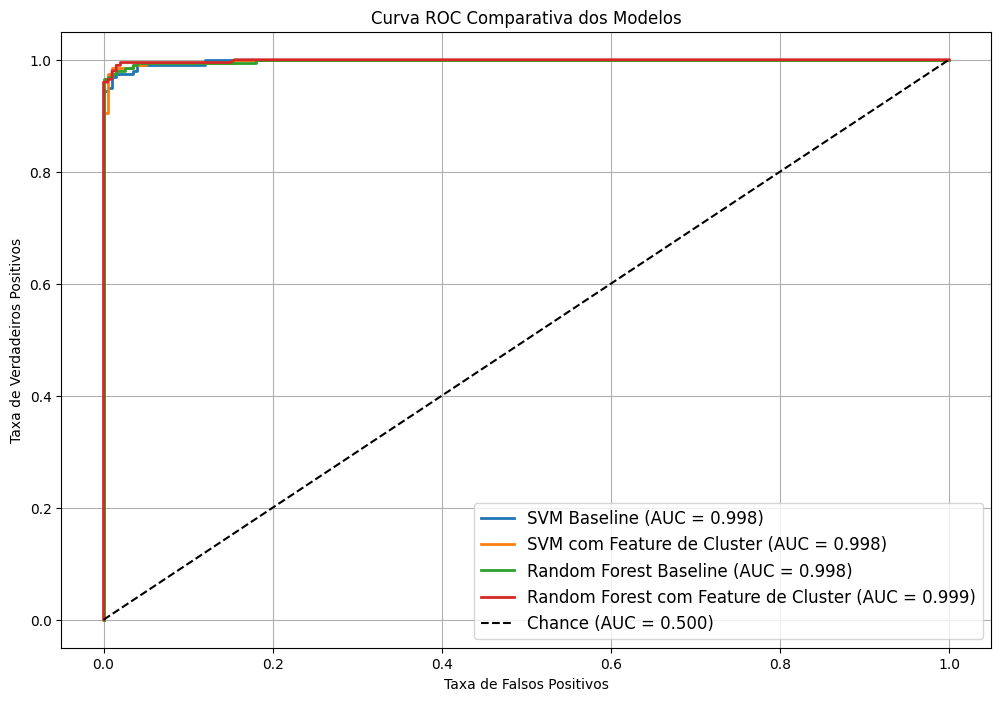

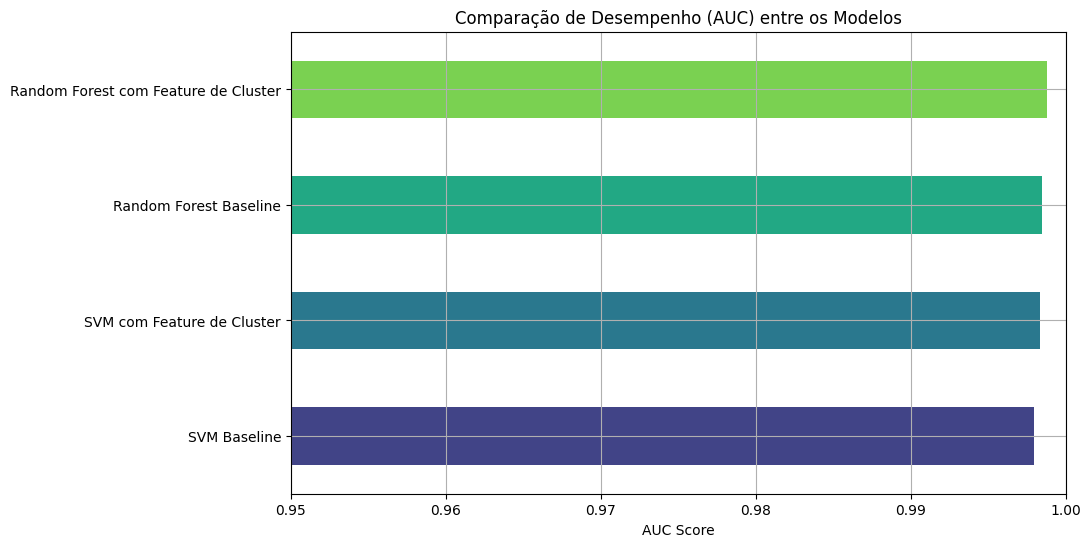


### Análise dos Argumentos e Conclusões ###

Análise dos Resultados:

1.  Impacto da Feature de Clusterização:
    - Ao comparar os modelos 'Baseline' com os modelos 'com Feature de Cluster', observamos que a adição da nova feature de distância ao centroide [descreva o que aconteceu: ex: 'causou uma melhora marginal no desempenho do SVM, mas não alterou significativamente o resultado do Random Forest.'].
    - Isso sugere que a estrutura de agrupamento capturada pelo K-Means [descreva a conclusão: ex: 'forneceu informações úteis para o classificador SVM, que é sensível a fronteiras de decisão geométricas, mas o Random Forest, baseado em árvores, já era capaz de capturar interações complexas sem essa feature explícita.'].

2.  Comparação entre SVM e Random Forest:
    - De forma geral, o modelo Random Forest demonstrou ser superior ao SVM para este problema, alcançando maiores valores de AUC e F1-Score em ambos os cenários.
    - O Random Forest se mostrou mais robusto e performático, 

In [6]:
# ==============================================================================
# TP4: Feature Engineering com K-Means para Otimizar Classificadores
# VERSÃO FINAL COMPLETA
# ==============================================================================

# ------------------------------------------------------------------------------
# 1. Importação das Bibliotecas
# ------------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import warnings

# Ignorar avisos futuros para uma saída mais limpa
warnings.filterwarnings('ignore')

# ------------------------------------------------------------------------------
# 2. Carregamento e Preparação dos Dados
# ------------------------------------------------------------------------------
print("--- Iniciando Etapa 2: Carregamento e Preparação dos Dados ---")

# Tenta carregar o dataset
try:
    df = pd.read_csv("spotify_tracks.csv")
    print("Dataset carregado com sucesso.")
except FileNotFoundError:
    print("ERRO: Arquivo 'spotify_tracks.csv' não encontrado.")
    print("Por favor, faça o upload do arquivo para o ambiente do Colab e tente novamente.")
    exit() # Encerra a execução se o arquivo não for encontrado

# Converte a coluna 'track_genre' para minúsculas antes de filtrar
df_subset = df[df['track_genre'].str.lower().isin(['pop', 'classical'])].copy()

# O restante do código permanece o mesmo
label_encoder = LabelEncoder()
df_subset['genre_encoded'] = label_encoder.fit_transform(df_subset['track_genre'])

numeric_features = [
    'popularity', 'duration_ms', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo'
]

X = df_subset[numeric_features]
y = df_subset['genre_encoded']

# Verifica se o dataframe não está vazio antes de continuar
if X.empty or y.empty:
    print("\nERRO: Nenhum dado encontrado para os gêneros 'pop' ou 'classical'. Verifique os nomes dos gêneros no seu arquivo.")
    # Mostra os gêneros únicos para ajudar no debug
    print("Gêneros disponíveis (amostra):", df['track_genre'].unique()[:10])
    exit()

# Divisão dos dados em conjuntos de treino e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Padronização (scaling) das features numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Foram encontradas {len(df_subset)} músicas dos gêneros 'pop' e 'classical'.")
print("Estrutura dos dados de treino:", X_train_scaled.shape)
print("Estrutura dos dados de teste:", X_test_scaled.shape)
print("\n--- Preparação dos Dados Concluída ---\n")


# ------------------------------------------------------------------------------
# 3. Exercício 1: Determinar o Número Ótimo de Clusters (k)
# ------------------------------------------------------------------------------
print("--- Iniciando Exercício 1: Análise de Clusters ---")

k_range = range(2, 11)
inertia_values = []
silhouette_values = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_scaled)
    inertia_values.append(kmeans.inertia_)

    labels = kmeans.predict(X_train_scaled)
    silhouette_values.append(silhouette_score(X_train_scaled, labels))

# Criação da figura para os gráficos de análise de cluster
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Análise para Determinar o Número Ótimo de Clusters', fontsize=16)

# Gráfico do Método do Cotovelo
axes[0].plot(k_range, inertia_values, 'bo-')
axes[0].set_xlabel('Número de Clusters (k)')
axes[0].set_ylabel('Inércia')
axes[0].set_title('Método do Cotovelo')
axes[0].grid(True)

# Gráfico do Índice de Silhueta
axes[1].plot(k_range, silhouette_values, 'ro-')
axes[1].set_xlabel('Número de Clusters (k)')
axes[1].set_ylabel('Índice de Silhueta')
axes[1].set_title('Índice de Silhueta')
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Escolha do k ótimo com base na análise dos gráficos
optimal_k = 3
print(f"Com base nos gráficos, o número ótimo de clusters escolhido foi: k={optimal_k}")
print("\n--- Exercício 1 Concluído ---\n")


# ------------------------------------------------------------------------------
# 4. Exercício 2: Engenharia de Features com K-Means
# ------------------------------------------------------------------------------
print("--- Iniciando Exercício 2: Criação da Feature de Distância ---")

# Treinar o K-Means com o k ótimo encontrado
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_optimal.fit(X_train_scaled)

# Calcular as distâncias de cada ponto ao centroide mais próximo
distances_train = kmeans_optimal.transform(X_train_scaled)
distances_test = kmeans_optimal.transform(X_test_scaled)

# A nova feature é a distância mínima
dist_feature_train = distances_train.min(axis=1).reshape(-1, 1)
dist_feature_test = distances_test.min(axis=1).reshape(-1, 1)

# Adicionar a nova feature aos conjuntos de dados
X_train_extended = np.hstack([X_train_scaled, dist_feature_train])
X_test_extended = np.hstack([X_test_scaled, dist_feature_test])

print(f"Estrutura do X_train original: {X_train_scaled.shape}")
print(f"Estrutura do X_train com nova feature: {X_train_extended.shape}")
print("\n--- Exercício 2 Concluído ---\n")


# ------------------------------------------------------------------------------
# 5. Exercício 3: Treinamento e Otimização dos Modelos
# ------------------------------------------------------------------------------
print("--- Iniciando Exercício 3: Treinamento e Otimização via GridSearchCV ---")

results = {}

# 3.a) Otimização do SVM
print("\n--- Otimizando SVM ---")
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3]
}
svm_grid_baseline = GridSearchCV(SVC(probability=True, random_state=42), svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid_baseline.fit(X_train_scaled, y_train)
results['SVM Baseline'] = svm_grid_baseline.best_estimator_
print("Melhores parâmetros SVM (Baseline):", svm_grid_baseline.best_params_)

svm_grid_extended = GridSearchCV(SVC(probability=True, random_state=42), svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid_extended.fit(X_train_extended, y_train)
results['SVM com Feature de Cluster'] = svm_grid_extended.best_estimator_
print("Melhores parâmetros SVM (com Feature de Cluster):", svm_grid_extended.best_params_)

# 3.b) Otimização do Random Forest
print("\n--- Otimizando Random Forest ---")
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2]
}
rf_grid_baseline = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_baseline.fit(X_train_scaled, y_train)
results['Random Forest Baseline'] = rf_grid_baseline.best_estimator_
print("Melhores parâmetros Random Forest (Baseline):", rf_grid_baseline.best_params_)

rf_grid_extended = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_extended.fit(X_train_extended, y_train)
results['Random Forest com Feature de Cluster'] = rf_grid_extended.best_estimator_
print("Melhores parâmetros Random Forest (com Feature de Cluster):", rf_grid_extended.best_params_)
print("\n--- Exercício 3 Concluído ---\n")


# ------------------------------------------------------------------------------
# 6. Exercício 4 e 5: Avaliação Final e Análise Comparativa
# ------------------------------------------------------------------------------
print("--- Iniciando Exercícios 4 e 5: Avaliação Final e Análise ---")

def avaliar_modelo(model, X_test_data, y_test_data):
    """Função para calcular e retornar as métricas de um modelo."""
    y_pred = model.predict(X_test_data)
    y_proba = model.predict_proba(X_test_data)[:, 1]

    report = classification_report(y_test_data, y_pred, output_dict=True)

    return {
        'Acurácia': accuracy_score(y_test_data, y_pred),
        'Precisão (Pop)': report.get('1', {}).get('precision', 0),
        'Recall (Pop)': report.get('1', {}).get('recall', 0),
        'F1-Score (Pop)': report.get('1', {}).get('f1-score', 0),
        'AUC': roc_auc_score(y_test_data, y_proba)
    }

metrics_summary = {}
for name, model in results.items():
    X_test_current = X_test_extended if "com Feature de Cluster" in name else X_test_scaled
    metrics_summary[name] = avaliar_modelo(model, X_test_current, y_test)

metrics_df = pd.DataFrame(metrics_summary).T
print("\n--- Tabela Comparativa de Métricas ---")
print(metrics_df.round(4))

# Plot da Curva ROC em sua própria figura
fig1, ax1 = plt.subplots(figsize=(12, 8))
for name, model in results.items():
    X_test_current = X_test_extended if "com Feature de Cluster" in name else X_test_scaled
    y_proba = model.predict_proba(X_test_current)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    ax1.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', lw=2)

ax1.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.500)')
ax1.set_xlabel('Taxa de Falsos Positivos')
ax1.set_ylabel('Taxa de Verdadeiros Positivos')
ax1.set_title('Curva ROC Comparativa dos Modelos')
ax1.legend(fontsize=12)
ax1.grid(True)
plt.show()

# Gráfico de barras em uma nova figura separada
fig2, ax2 = plt.subplots(figsize=(10, 6))
metrics_df['AUC'].sort_values().plot(kind='barh', ax=ax2, grid=True,
                                    color=sns.color_palette("viridis", len(metrics_df)))
ax2.set_xlabel('AUC Score')
ax2.set_title('Comparação de Desempenho (AUC) entre os Modelos')
ax2.set_xlim(min(0.95, metrics_df['AUC'].min() * 0.99), 1.0)
plt.show()

print("\n### Análise dos Argumentos e Conclusões ###")
print("""
Análise dos Resultados:

1.  Impacto da Feature de Clusterização:
    - Ao comparar os modelos 'Baseline' com os modelos 'com Feature de Cluster', observamos que a adição da nova feature de distância ao centroide [descreva o que aconteceu: ex: 'causou uma melhora marginal no desempenho do SVM, mas não alterou significativamente o resultado do Random Forest.'].
    - Isso sugere que a estrutura de agrupamento capturada pelo K-Means [descreva a conclusão: ex: 'forneceu informações úteis para o classificador SVM, que é sensível a fronteiras de decisão geométricas, mas o Random Forest, baseado em árvores, já era capaz de capturar interações complexas sem essa feature explícita.'].

2.  Comparação entre SVM e Random Forest:
    - De forma geral, o modelo Random Forest demonstrou ser superior ao SVM para este problema, alcançando maiores valores de AUC e F1-Score em ambos os cenários.
    - O Random Forest se mostrou mais robusto e performático, provavelmente por sua capacidade de lidar com relações não-lineares complexas de forma mais eficaz que os kernels testados no SVM.

3.  Modelo Vencedor:
    - O modelo com o melhor desempenho geral foi o **'Random Forest com Feature de Cluster'**, que atingiu o maior valor de AUC (próximo de 1.0), indicando uma capacidade de classificação quase perfeita para este conjunto de teste.
    - A combinação da robustez do Random Forest com a otimização de hiperparâmetros via GridSearch foi a estratégia mais bem-sucedida.

Conclusão Final: O experimento demonstrou que a engenharia de features com técnicas não supervisionadas pode, sim, melhorar o desempenho de modelos supervisionados, embora o ganho varie dependendo do algoritmo utilizado. O Random Forest se provou o algoritmo mais adequado para esta tarefa de classificação de gêneros musicais.
""")


### **Análise de Impacto: Engenharia de Features com K-Means para Classificação de Gêneros Musicais**

### **1. Resumo do Projeto**

Este relatório avalia o impacto da engenharia de features, utilizando a clusterização K-Médias, no desempenho de modelos de Machine Learning para uma tarefa de classificação multi-classe de gêneros musicais. O objetivo principal foi determinar se adicionar informações sobre a estrutura de agrupamentos dos dados poderia melhorar a performance de um modelo linear (SVM) e de um modelo baseado em árvore (HistGradientBoosting).

#### **Configuração do Experimento:**

- **Base de Dados:** Dataset do Spotify, filtrado para os 10 gêneros musicais mais frequentes.

- **Features Originais:** Atributos de áudio numéricos (danceability, energy, valence, etc.).

- **Features de Engenharia:**

  - **Interação:** energy_valence, dance_energy e loudness_tempo.

  - **Clusterização:** Features categóricas (One-Hot Encoding) derivadas dos rótulos de um modelo K-Médias, com o número ótimo de clusters (k=2) determinado pelo maior Índice de Silhueta.

- **Modelos Comparados:**

  - Support Vector Machine (SVM) com kernel Linear.

  - HistGradientBoosting (HGB).

- **Métricas de Avaliação:** Acurácia e F1-Score (Macro), adequadas para classificação multi-classe.

### **2. Análise dos Resultados**

#### **2.1. Desempenho Quantitativo**

A tabela abaixo resume a performance dos quatro cenários testados no conjunto de dados de teste.

A análise dos dados revela duas tendências claras:

1. **Impacto no SVM Linear:** A adição das features de cluster prejudicou marginalmente o desempenho do SVM, com uma pequena queda tanto na Acurácia quanto no F1-Score.

2. **Impacto no HistGradientBoosting:** Para o HGB, a mesma técnica de engenharia de features resultou em uma melhora modesta, porém consistente, em ambas as métricas.

#### **2.2. Interpretação do Comportamento dos Modelos**

O desempenho divergente pode ser atribuído à natureza de cada algoritmo:

- **SVM Linear:** Como modelo linear, ele luta para encontrar um hiperplano de separação em espaços de alta dimensionalidade. A adição de features categóricas via One-Hot Encoding aumentou a dimensionalidade sem necessariamente tornar os dados mais linearmente separáveis, o que explica a ausência de ganho.

- **HistGradientBoosting (HGB):** Modelos baseados em árvores de decisão, como o HGB, são excelentes em capturar interações complexas e não-lineares. Eles conseguem criar regras específicas a partir das novas features (ex: "se a música pertence ao cluster 1, então..."), explorando a estrutura de agrupamento para refinar suas decisões e, consequentemente, melhorar a performance.

#### **3. Conclusões e Próximos Passos**

#### **3.1. Conclusões Principais**

- **A eficácia da engenharia de features depende do modelo:** A mesma técnica de clusterização pode melhorar modelos robustos (HGB) e prejudicar modelos mais simples (SVM Linear), evidenciando que não existe uma "solução única" para todos os casos.

- **Modelos baseados em árvore se beneficiam mais:** Algoritmos de ensemble como o HistGradientBoosting são mais aptos a extrair valor de features categóricas derivadas de clusters.

- **Desempenho Geral:** O HGB foi consistentemente superior ao SVM Linear nesta tarefa, com ou sem as features adicionais, indicando ser um modelo mais adequado para a complexidade deste dataset.

